# Прогностическая модель рассеянного склероза

**Стэк:** *numpy, pandas, matplotlib, seaborn, tensorflow, sklearn.*

**Цель:** *написать прогностическую модель для определения вероятности рассеянного склероза. Где 0 - нет склероза, 1 - есть склероз.*

In [10]:
import matplotlib.pyplot as plt # библиотека для построения графиков и диаграмм
import numpy as np              # библиотека для научных вычислений и работы с массивами чисел
import os                       # библиотека для работы с файлами и каталогами операционной системы
import pandas as pd             # библиотека для работы с табличными данными
import pickle                   # Сохранение/загрузка словаря
import pydicom                  # библиотека для работы с DICOM-изображениями в медицине.
import seaborn as sns           # график матрицы ошибок

from math import floor          # математическая библиотека Python
from PIL import Image           # библиотека для работы с изображениями
from sklearn.model_selection import train_test_split # Разбиение на тренировочную и тестовую выборки
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay # Матрица ошибок классификатора
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score # метрики для теста

import tensorflow as tf
# для создания сети
from tensorflow.keras.models import Sequential
# для создания слоев
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization, SpatialDropout2D
# для работы с изображениями
from tensorflow.keras.preprocessing import image
# оптимизатор
from tensorflow.keras.optimizers import Adam
# импортируем коллбэки
from keras.callbacks import  ReduceLROnPlateau,  EarlyStopping, ModelCheckpoint

# Remove warnings
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline


# Загрузка выборок

Данные: https://mosmed.ai/en/datasets/aie21selftestmri/

```
PAN_BOT_anon             22
ING15_GB3_anon           24
INTERA_GKB12_anon        25
MRI84653_anon            29
EXCELMRI_GP22_anon      369
EXCELMRI_DC3_anon       481
EXCELMRI_GP8_anon       536
EXCELMRI_GVV2_anon      681
EXCELMRI_GKB71_anon     691
EXCELMRI_GKB57_anon     718
EXCELMRI_GP9_anon       818
HDX_MR_anon             828
EXCELMR_GB13_anon       830
EXCELMR_VERES_anon      832
EXCELMRI_GP134_anon     885
EXCELMRI_GKB36_anon     957
EXCELMRI_GP19_anon      967
EXCELMRI_GP209_anon    1086
EXCELMRI_GP212_anon    1154
EXCELMRI_GP214_anon    1204
EXCELMRI_GKB50_anon    1226
EXCELMRI_GP195_anon    1302
EXCELMRI_KDC4_anon     1306
EXCELMRI_GVV3_anon     1315
MR_GP46F1_anon         1339
EXCELMRI_GP52_anon     1359
EXCELMRI_GP67_anon     1392
EXCELMRI_GP68_anon     1574
EXCELMRI_MUH_anon      1633
EXCELMR1_GB1_anon      1644
EXCELMR_NPPCS_anon     1717
EXCELMRI_GP45_anon     1718
EXCELMRI_GP6_anon      1764
EXCELMRI_GP220_anon    1816
EXCELMR_YUD_anon       1833
EXCELMRI_GP2_anon      1947
EXCELMRI_KDC6_anon     2035
EXCELMRI_SM4_anon      2102
EXCELMR2_GB1_anon      2113
EXCELMRI_GVV1_anon     2312
ING30_MDGKB_anon       2410
EXCELMRI_GKB29_anon    2873
Name: major_dir, dtype: int64

labels.xlsx

        study_uid	                                        sclerosis
0	1.2.643.5.1.13.13.12.2.77.8252.011411090410101...	0
1	1.2.643.5.1.13.13.12.2.77.8252.131500041112120...	1
2	1.2.643.5.1.13.13.12.2.77.8252.010305060009140...	0
3	1.2.643.5.1.13.13.12.2.77.8252.071406031309010...	1
4	1.2.643.5.1.13.13.12.2.77.8252.121511041410151...	0
...	...	...
167	1.2.643.5.1.13.13.12.2.77.8252.111211060701140...	1
168	1.2.643.5.1.13.13.12.2.77.8252.100815141103051...	0
169	1.2.643.5.1.13.13.12.2.77.8252.060804010900090...	1
170	1.2.643.5.1.13.13.12.2.77.8252.030410101303070...	0
171	1.2.643.5.1.13.13.12.2.77.8252.040811010609121...	1
172 rows × 2 columns
```
В наборе данных есть фотографии разных размеров. Вот список их размеров shape в списке [(384, 416), (748, 640), (384, 384), (512, 512), (384, 384), (768, 768), (288, 288), (640, 640), (384, 384), (384, 384), (768, 768), (22, 192, 192), (384, 384), (768, 768), (640, 640), (512, 512), (768, 768), (384, 384), (576, 576), (384, 384), (384, 384), (768, 768), (768, 768), (384, 384), (768, 768), (576, 576), (23, 192, 192), (48, 128, 128), (512, 512), (25, 192, 192), (768, 768), (192, 192), (384, 384), (384, 384), (384, 384), (512, 512), (640, 640), (768, 768), (512, 512), (640, 640), (384, 384), (768, 768)]

Всего 43 папки. Внутри каждой 4 исследования. Внутри каждого исследования папки с DICOM-изображениями. Общий объем 51 Гб. Предаврительно оставили только поперечные разрезы (продольные не нужны). labels.xlsx файл содержит информацию - результат исследования, наличие или отсутствие склероза.

Для начала, нужно определить какой dcm к какому классу относится. Напишем код на основе таблицы labels.xlsx, заменим названия исследований на названия DICOM-изображений. Сохраним в новой таблице labels_plus.xlsx. 
Масштабируем DICOM-изображения для того, чтобы привести значения пикселей к одному диапазону значений и уменьшить влияние шумов на изображение.
Далее распределим dcm по выборкам и сгенерим на их основе изображения одного размера. Сохраним изображения по соответсвующим каталогам. Напишем функции для подготовки данных к машинному обучению.

```
labels_plus.xlsx

        path	                                                sclerosis sample
0	mosmed_ai_datasets\EXCELMRI_DC3_anon\1.2.643.5...	0	  train
1	mosmed_ai_datasets\EXCELMRI_DC3_anon\1.2.643.5...	0	  train
2	mosmed_ai_datasets\EXCELMRI_DC3_anon\1.2.643.5...	0	  train
3	mosmed_ai_datasets\EXCELMRI_DC3_anon\1.2.643.5...	0	  train
4	mosmed_ai_datasets\EXCELMRI_DC3_anon\1.2.643.5...	0	  train
...	...	...	...
51862	mosmed_ai_datasets\EXCELMRI_GKB50_anon\1.2.643...	1	  train
51863	mosmed_ai_datasets\EXCELMRI_GKB50_anon\1.2.643...	1	  test
51864	mosmed_ai_datasets\EXCELMRI_GKB50_anon\1.2.643...	1	  train
51865	mosmed_ai_datasets\EXCELMRI_GKB50_anon\1.2.643...	1	  test
51866	mosmed_ai_datasets\EXCELMRI_GKB50_anon\1.2.643...	1	  train
51867 rows × 3 columns
```

```python
# Создание набора данных из изображений в каталоге
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='binary',
    color_mode='grayscale',
    batch_size=16,
    image_size=(512, 512),
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset='training')

# Создание набора данных для валидации
val_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='binary',
    color_mode='grayscale',
    batch_size=16,
    image_size=(512, 512),
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset='validation')

# Создание набора данных для теста
test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='binary',
    color_mode='grayscale',
    batch_size=16,
    image_size=(512, 512),
    shuffle=True,
    seed=42)

# Сохраняем датасеты
tf.data.Dataset.save(train_dataset, tofolder)
tf.data.Dataset.save(val_dataset, tofolder)
tf.data.Dataset.save(test_dataset, tofolder)
```
```
Found 41493 files belonging to 2 classes.
Using 33195 files for training.
Found 41493 files belonging to 2 classes.
Using 8298 files for validation.
Found 10374 files belonging to 2 classes.
```
Пример DICOM-изображений из выборок.

<div>
    <img src="subplot.png" alt="альтернативный текст" title="заголовок изображения" width="1000" style="float: left; margin-right: 20px">
</div>

<style>
    img {
        border: 1px solid black;
    }
</style>

Все это уже сделали в `Notebook make_datasets.ipynb`. Можно приступать к созданию модели машинного обучения. Для начала работы нужно только загрузить выборки.


In [ ]:
%%time
# Загрузка объекта набора данных из файла
train_dataset = tf.data.Dataset.load('datasets_16/train_dataset')
# Загрузка объекта набора данных из файла
val_dataset = tf.data.Dataset.load('datasets_16/val_dataset')
# Загрузка объекта набора данных из файла
test_dataset = tf.data.Dataset.load('datasets_16/test_dataset')


# Архитектура

Обычно, чтобы повысить скорость обучения модели, наилучшим вариантом является использование простой архитектуры с большим набором данных. Это связано с тем, что более сложные архитектуры с меньшим количеством данных могут привести к переобучению модели, то есть модель может слишком хорошо запомнить обучающие данные и не будет обобщаться на новые данные.

Кроме того, использование большого набора данных позволяет увеличить разнообразие данных, что может помочь предотвратить переобучение и повысить обобщающую способность модели. Больший объем данных также позволит модели выявить более сложные зависимости в данных, что может улучшить ее точность.

Количество фильтров, необходимых для обработки изображений размера (512, 512, 1), зависит от конкретной задачи. В общем случае, чем больше фильтров, тем больше признаков может быть извлечено из изображения, но это также может привести к более высокой стоимости вычислений.

Если использовать сверточную нейронную сеть для классификации изображений, то оптимальное количество фильтров может быть найдено путем экспериментов и настройки гиперпараметров. Обычно начинают с меньшего количества фильтров, например, 16 или 32, и постепенно увеличивают число фильтров в процессе обучения, чтобы достичь лучшей точности.

Однако, если используеть предобученные модели или стандартные архитектуры, то может быть определено оптимальное количество фильтров для данной архитектуры. Например, в стандартной архитектуре VGG16 для классификации изображений, используются 64 фильтра в первом слое, затем 128 фильтров во втором слое и т. д.

В целом, нет жестких правил для выбора количества фильтров, и это зависит от конкретной задачи и используемой архитектуры.

Будем использовать сверточные нейронные сети (Convolutional Neural Networks).

In [3]:
input_shape = (512, 512, 1)

model = Sequential()

# Сверточный слой с 32 фильтрами и размером ядра (3,3).
model.add(Conv2D(32, (3, 3), activation='elu', input_shape=input_shape))
# Пулинг слой для уменьшения размерности изображения.
model.add(MaxPooling2D((3, 3)))
# Сверточный слой с 32 фильтрами и размером ядра (3,3).
model.add(Conv2D(64, (3, 3), activation='elu'))
# Пулинг слой для уменьшения размерности изображения.
model.add(MaxPooling2D((3, 3)))
# Сверточный слой с 32 фильтрами и размером ядра (3,3).
model.add(Conv2D(128, (3, 3), activation='elu'))
# Пулинг слой для уменьшения размерности изображения.
model.add(MaxPooling2D((3, 3)))

# Блок классификации
# Слой преобразования многомерных данных в одномерные 
model.add(Flatten())
# Полносвязный слой с 128 нейронами и функцией активации relu.
model.add(Dense(128, activation='elu'))
# Слой Dropout для регуляризации модели.
model.add(Dropout(0.5))
# Выходной слой с одним нейроном и функцией активации sigmoid.
model.add(Dense(2, activation='sigmoid'))

# Сводка архитектуры автокодировщика
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 510, 510, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 170, 170, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 168, 168, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 54, 54, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 18, 18, 128)      0

Для избежания переобучения используются BatchNormalization и Dropout слои, а также SpatialDropout2D для обучения на больших изображениях.

Архитектура сверточной нейронной сети включает три сверточных слоя (32, 64 и 128 фильтров, размер ядра - 3x3) с функцией активации ELU, после которых следуют слои пулинга MaxPooling2D, уменьшающие размерность выходных данных каждого сверточного слоя вдвое по обеим осям. Слои BatchNormalization нормализуют выходные данные предыдущих слоев, ускоряя процесс обучения.

Для борьбы с переобучением добавлены SpatialDropout2D слои, которые случайным образом отключают каждый из фильтров сверточных слоев с определенной вероятностью.

Следующие слои - полносвязные слои с функцией активации ELU и Dropout слоями. В конце сети находится выходной слой с двумя нейронами и сигмоидальной функцией активации для бинарной классификации.

# Обучение

В процессе обучения нейронной сети используются коллбэки EarlyStopping и ReduceLROnPlateau для контроля качества обучения и оптимизации процесса.

EarlyStopping останавливает процесс обучения, если качество модели на проверочных данных перестает улучшаться, что помогает избежать переобучения.

ReduceLROnPlateau динамически изменяет скорость обучения в зависимости от изменения качества модели на проверочных данных. Если качество модели на проверочных данных не улучшается в течение заданного числа эпох, скорость обучения уменьшается на заданный коэффициент.

ModelCheckpoint сохраняет веса модели во время ее обучения, что полезно для сохранения лучших весов или для продолжения обучения с сохраненных весов.

Epoch 1/200
2075/2075 [==============================] - 1935s 932ms/step - loss: 0.1884 - accuracy: 0.9191 - val_loss: 0.2116 - val_accuracy: 0.9087 - lr: 1.0000e-04
Epoch 2/200
2075/2075 [==============================] - 1900s 915ms/step - loss: 0.1375 - accuracy: 0.9439 - val_loss: 0.1945 - val_accuracy: 0.9177 - lr: 1.0000e-04
Epoch 3/200
2075/2075 [==============================] - 1848s 890ms/step - loss: 0.1114 - accuracy: 0.9557 - val_loss: 0.1965 - val_accuracy: 0.9236 - lr: 1.0000e-04
Epoch 4/200
2075/2075 [==============================] - ETA: 0s - loss: 0.0914 - accuracy: 0.9634
Epoch 4: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.
2075/2075 [==============================] - 1842s 888ms/step - loss: 0.0914 - accuracy: 0.9634 - val_loss: 0.1972 - val_accuracy: 0.9237 - lr: 1.0000e-04
Epoch 5/200
2075/2075 [==============================] - 1866s 899ms/step - loss: 0.0534 - accuracy: 0.9805 - val_loss: 0.1938 - val_accuracy: 0.9305 - lr: 6.0000e-05
Ep

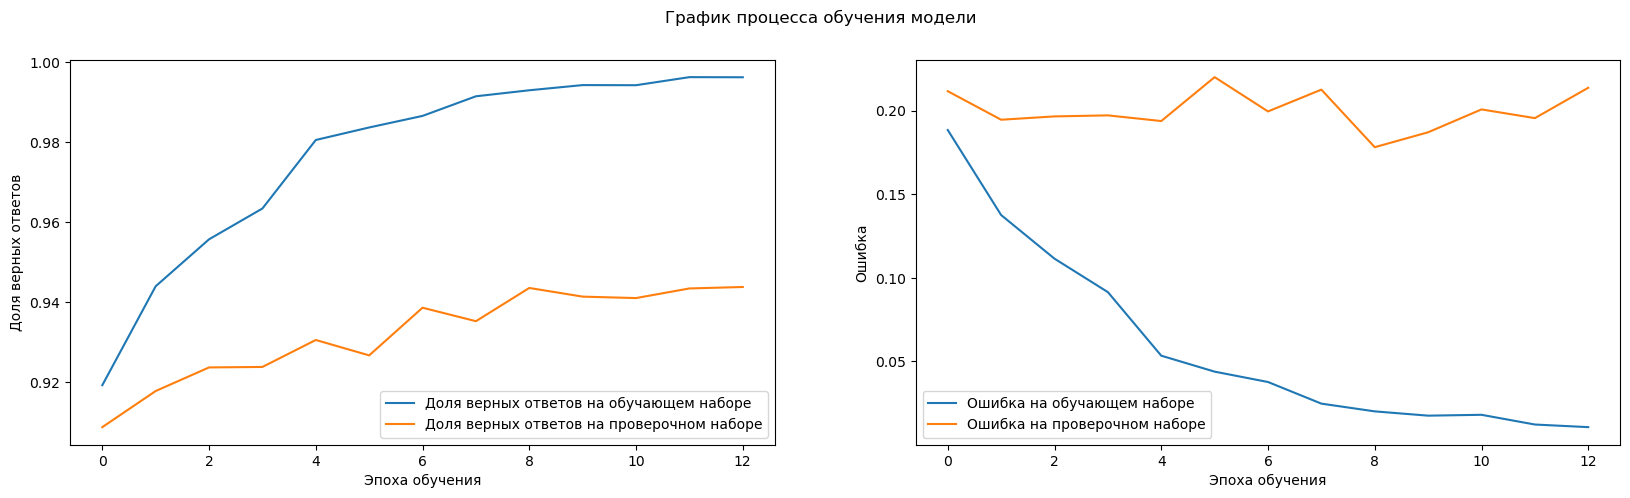

CPU times: total: 2d 7h 55min 33s
Wall time: 6h 53min 44s


In [4]:
%%time
model.compile(loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True), 
              optimizer=Adam(0.0001), # Оптимизатор
              metrics=['accuracy'])
# Колбэки
earlystop=EarlyStopping(monitor='val_loss', 
                        min_delta=0,
                        patience=4,
                        verbose=1,
                        baseline=None,
                        restore_best_weights=True)

reduceLROnPlateau = ReduceLROnPlateau(monitor='val_loss', 
                                      factor=0.6, 
                                      patience=2, 
                                      verbose=1)

# Создаем коллбек сохранения весов
checkpoint = ModelCheckpoint("weights_dataset16_heavy.h5", save_weights_only=True, save_best_only=True)

# В любой момент в будущем мы можем загрузить сохраненные веса и продолжить обучение
if os.path.isfile('weights_dataset16_heavy.h5'):
    # Загружаем модель и ее веса из файла weights.h5
    model.load_weights('weights_dataset16_heavy.h5')

store = model.fit(train_dataset,
                  shuffle=True,  # --------------------- перемешивание данных для равномерного обучения, соответствие экземпляра и метки сохраняется 
                  batch_size=256,  # -------------------- размер пакета, который обрабатывает нейронка перед одним изменением весов
                  epochs=200,  # ------------------------ epochs - количество эпох обучения
                  verbose=1,  # ------------------------ 0 - не визуализировать ход обучения, 1 - визуализировать
                  callbacks=[earlystop, reduceLROnPlateau, checkpoint],
                  validation_data=val_dataset)

# Вывод графиков точности и ошибки
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
fig.suptitle('График процесса обучения модели')
ax1.plot(store.history['accuracy'], 
               label='Доля верных ответов на обучающем наборе')
ax1.plot(store.history['val_accuracy'], 
               label='Доля верных ответов на проверочном наборе')
ax1.xaxis.get_major_locator().set_params(integer=True)
ax1.set_xlabel('Эпоха обучения')
ax1.set_ylabel('Доля верных ответов')
ax1.legend()

ax2.plot(store.history['loss'], 
               label='Ошибка на обучающем наборе')
ax2.plot(store.history['val_loss'], 
               label='Ошибка на проверочном наборе')
ax2.xaxis.get_major_locator().set_params(integer=True)
ax2.set_xlabel('Эпоха обучения')
ax2.set_ylabel('Ошибка')
ax2.legend()
plt.show()


# Тест

649/649 [==============================] - 124s 191ms/step


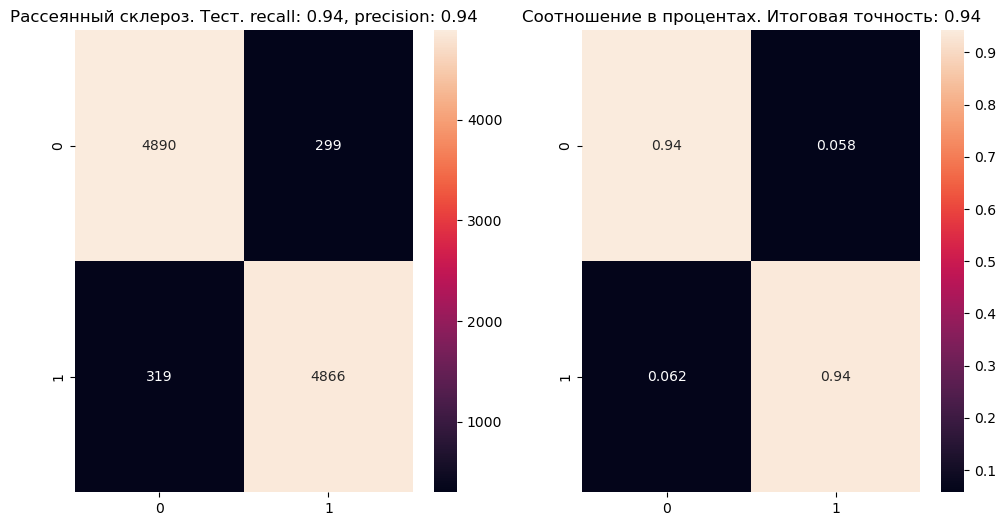

In [9]:
# Загрузка
model = tf.keras.models.load_model('model.h5')

# Получаем прогнозы для val_ds
y_pred = np.argmax(model.predict(test_dataset), axis=-1)
# Получаем истинные метки для val_ds
y_true = np.concatenate([y for x, y in test_dataset], axis=0)

# проверим модель на эффективность. Выводим матрицу ошибок
recall = ("recall: %.2f" % recall_score(y_true, y_pred))
precision = ("precision: %.2f" % precision_score(y_true, y_pred))

# Создаем фигуру с двумя подграфиками, расположенными рядом
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Строим вторую тепловую карту на втором подграфике
cm = tf.math.confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', ax=axes[0])
axes[0].set_title(f'Рассеянный склероз. Тест. {recall}, {precision}')

# Строим первую тепловую карту на первом подграфике
cm = confusion_matrix(np.argmax(tf.keras.utils.to_categorical(y_true.reshape(-1), 2), axis=1),
                      y_pred, normalize='true')
sns.heatmap(cm, annot=True, ax=axes[1])
axes[1].set_title('Соотношение в процентах. Итоговая точность: {0}'.format(round((cm[0][0]+cm[1][1])/2, 2)))

plt.show()

# Сохранение
# model.save('model_dataset16_heavy.h5')
# Загрузка
# model = tensorflow.keras.models.load_model('model')


### Программа. Алгоритм предобработки и прогноза
Программа принимает путь к рентгеновскому снимку (jpg, dicom) и возвращает вероятность (от 0 до 1) рассеянного склероза.
```python
text = '''
def predict_proba(path):
    
    import os
    import numpy as np
    import pydicom                  # библиотека для работы с DICOM-изображениями в медицине.
    import tensorflow as tf         # библиотека для создания сети

    from PIL import Image           # библиотека для работы с изображениями
    from tensorflow import keras
    from tensorflow.keras.preprocessing import image

    # Модель 
    model = tf.keras.models.load_model('model.h5')

    # функция для принятия на вход dcm формат        
    def read_dcm(path):
        # Конвертируем
        dcm = pydicom.dcmread(path)
        img = dcm.pixel_array.astype(np.float32) # преобразование изображения в numpy-массив
        intercept = dcm.RescaleIntercept if 'RescaleIntercept' in dcm else 0.0
        slope = dcm.RescaleSlope if 'RescaleSlope' in dcm else 1.0
        img = slope * img + intercept # масштабирование
        if len(img.shape) > 2:
            img = img[0]
        img -= img.min()
        img /= img.max()
        img *= 255.0
        img = img.astype('uint8')

        img = Image.fromarray(img).convert('L') # Преобразование в изображение в оттенках серого
        img = img.resize((512, 512)) # Изменение размера изображения
        img = image.img_to_array(img)
        return tf.expand_dims(img, 0)  # добавляем дополнительное измерение (batch size)

    def read_img(path):
        img = image.load_img(path, color_mode='grayscale', target_size=(512, 512))
        img_array = image.img_to_array(img)
        return tf.expand_dims(img_array, 0)  # добавляем дополнительное измерение (batch size)

    def predict_proba(path):
        if os.path.isfile(path):
            if path.endswith('.dcm'):
                img_array = read_dcm(path)
            elif path.endswith('.jpg'):
                img_array = read_img(path)
            else:
                print('Unsupported file extension')
        else:
            print('File not found')

        predictions = model.predict(img_array)
        score = tf.nn.softmax(predictions[0])

        return round(float(score[1]), 2)

    return predict_proba(path)

'''
# сохранение
with open('model.py', 'w+', encoding="utf-8",) as f:  
    f.write(text.strip())
```

```python
import model
model.predict_proba("example/image_example.dcm")
```
```
1/1 [==============================] - 0s 120ms/step
0.59
```

```python
import model
model.predict_proba("example/image_example_1.jpg")
```
```
1/1 [==============================] - 0s 68ms/step
0.27
```